In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
import CRTS_paper_modules as mod
import datetime
from matplotlib import rcParams
from scipy.optimize import curve_fit
from collections import OrderedDict

To make Fig. 4 I would read files in a given mag range,  and then loop over objects in 11)a) , setting appropriate fc ( as in file   SigmaG_chi_-StarsB.txt  in  data_products/Fig_3_data/2016-06-07/   ) 

Instead of using a single fc for the entire range, I apply the fitted correction coefficient  power law:


$\sigma_{G}(\chi_{Blue}) = f_{c} = a \, \log_{10}(\Delta_{t}) + b$ , 

where $a$ and $b$ are set for each magnitude from the linear fit  (I read them in from data_products/Fig_3_data/2016-06-07/fc_starsB_a_b_coeff.txt  ) 

    mag     | a       | b 
    17-18   | 0.01829 | 0.08517  
    18-18.5 | 0.01983 | 1.066
    18.5-19 | 0.-0187 | 1.2487

In [15]:
# Read in the linear correction coefficients....
File = '/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_3_data/2016-06-07/fc_starsB_a_b_coeff.txt'
colnames = open(File,'r').read().splitlines()[0][1:].split()
datatable = np.genfromtxt(File, dtype=float)
coeffs = {}
for label, column in zip(colnames, datatable.T):
    coeffs[label] = column
    
# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_4_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_4_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

print('Today we will save our Fig_4 files in %s'%outDir)

Today we will save our Fig_4 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/


## Read in xi, ei  for the objects in a given mag range ... Not the same as Fig_3, because there we only have samples of log_tau

In [17]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from  ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for  48250 , stars from CRTS


Need to loop that, and the calculation of xi, ei  below,  over the three magnitude ranges... 

In [48]:
# Set the magnitude range 
Min  = 18.5
Max  = 19

objects_in_cut = {}

mag = 'r'
cut_mag = mag

print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))

# use only qso and blue stars since these are the ones that we are plotting ...
good_ids_S_blue = mod.cut_stars(star_cat = star_cat, mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                          gi_Max=1, cut_mag=cut_mag + '_mMed')

good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                           cut_mag=cut_mag)
objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'qso':good_ids_QSO}


## Since I'm only using r_cut,   I won't compare it with g_cut .  Thus making r_bin is the same as r_cut  

bins = {}
bin_types = ['r_cut']

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]
    
## Read in the xi, ei for objects in that mag range ... 
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print 'Reading in xi, ei for bin ', b
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
good_ids_QSO = bins[b]['qso']

qso, starB, =  mod.read_xi_ei(inDirStars, good_ids_S_blue, inDirQSO, good_ids_QSO)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'qso':qso}


Using now only lightcurves with SDSS  18.500000< r < 19.000000

 These cuts reduced the number of stars  in the sample from 48250  to  1496
Returning only QSO which had an SDSS counterpart within 0.000278 radians

 These cuts reduced the number of qso  in the sample from 7601  to  747
Reading in xi, ei for bin  r_cut
making new delflx, tau, xi arrays


----- Already read 99% of qso 

----- Already read 99% of Blue Stars 



## Calculate sigma approx and sigma full, applying correction factor to errors in each bin 

In [19]:
# for all imports of my functions, 
# make python aware of my packages...
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import variabilityFunctions as varF


In [49]:
Min

18.5

In [50]:
# set the bin number 
nbins = 200 

          
print('Today we will save our Fig_4 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in ['qso','starsB'] : # out_dic[b].keys()
    print '\n For obj = ', obj
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic['r_cut'][obj][0]
    tau =  out_dic['r_cut'][obj][1]
    e_ij = out_dic['r_cut'][obj][2]


    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Make an array of correction coefficients per bin, using the coefficients from the file ...  
    a = coeffs['a'][coeffs['rMagMin'] == Min]
    b = coeffs['b'][coeffs['rMagMin'] == Min]
    binned_fc =  a* np.log10(binned_tau[0]) + b
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    
    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]


    # Which point belongs to which bin
    bin_number  = binned_tau[2]

    ####  Panel 1 : Standard Deviation 
    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  


    ##### Panel 2  : Gaussian rms  
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    # Loop over all bins  calculating approximate mu and sigma 
    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        fc_bin = binned_fc[N-1]
        ei = fc_bin * e_ij[bin_number == N]
    
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 

    # Save the results of calculation  : Panel 1,2,3,4 
    fname = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    

    data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count, binned_fc))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount  binFcorr'
    np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print 'Results saved as ', fname

print 'Done with calculating panel data '    

Today we will save our Fig_4 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/

 For obj =  qso
 --- Calculating mu, sigma for bin 200 Results saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_18.5-19_qso.txt

 For obj =  starsB
 --- Calculating mu, sigma for bin 200 Results saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_18.5-19_starsB.txt
Done with calculating panel data 


## Read in plotting data from  saveFiles

If you have  already calculated statistics for each bin,  can simply read the file, and proceed to plotting, skipping steps above 

In [53]:

plot_data = OrderedDict()

Min_arr = [17,18,18.5]
Max_arr = [18, 18.5, 19]

for mag in Min_arr:
    plot_data[mag] = OrderedDict()
    
for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for obj in ['qso','starsB']:
        plot_data[Min][obj] = {}
        
        fname =  outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
        print 'Loading... ', fname 
        
        colnames = open(fname,'r').read().splitlines()[0][1:].split()
        d = np.genfromtxt(fname, dtype=float)
        
        for label, column in zip(colnames, d.T):
            plot_data[Min][obj][label] = column
        


Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_17-18_qso.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_17-18_starsB.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_18-18.5_qso.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_18-18.5_starsB.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_18.5-19_qso.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-08/r_cut_18.5-19_starsB.txt


## Plot the data 

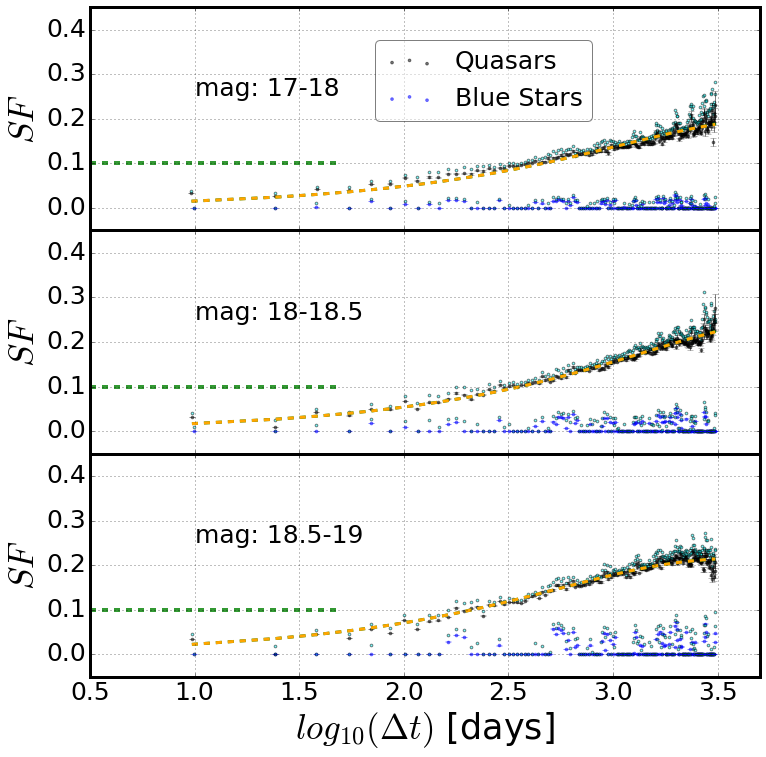

In [73]:
#%matplotlib inline

def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf
        
        
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25
rcParams.update({'figure.autolayout': False})


obj_arr = ['qso',  'starsB']
labels_arr = ['Quasars', 'Blue Stars']
colors = ['black','blue']

# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 7
p_al   = 0.5 

# y limits for SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

b = 'r_cut'

fig,ax = plt.subplots(3,1, figsize=(12,12), sharex=True)
fig.subplots_adjust(hspace=0)
for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for j in range(len(obj_arr)):
        obj = obj_arr[j]
        
        plot = plot_data[Min][obj]
        
        ax[i].scatter(np.log10(plot['meanTau']), plot['sigmaApprox'],  s=p_size, 
                    alpha=p_al, label=labels_arr[j], 
                      color=colors[j])
        err_sig = plot['sigmaApprox']* 1.06 / np.sqrt(plot['binCount'])
        
        ax[i].errorbar(np.log10(plot['meanTau']), plot['sigmaApprox'],err_sig, linestyle='None',
                       color=colors[j],   alpha=p_al)#
        
        ax[i].scatter(np.log10(plot['meanTau']), plot['sigmaFull'], s=p_size, 
                    alpha=p_al, c ='cyan')
        
        
        if obj == 'qso' : 
            # Calculate the model DRW fit for QSO
        
            xdata = plot['meanTau']
            sf = plot['sigmaApprox']
            popt, pcov = curve_fit(model_sf, xdata, sf)
            y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 

            # Fold-in the error to the model SF , plot 
            # both folded and not-folded version 
            y_fold = np.sqrt((y ** 2.0)+ (err_sig ** 2.0) )
            ax[i].plot(np.log10(xdata), y_fold , lw=3, c = 'green', ls='--')
            ax[i].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')

            # text = r'$ \mathrm{Model:}\ \tau=%.3f \,\mathrm{days} , \ SF_{\infty}=%.3f \,\mathrm{mag}$'%(popt[1],popt[0])
            # ax[i].text(x=0.75, y=0.3,s = text )

            
for i in range(len(Min_arr)) :
    
    ax[i].text(1.0, 0.25, 'mag: '+str(Min_arr[i])+'-'+str(Max_arr[i]) )
  
    ax[i].set_ylabel(r'$SF$')
    ax[i].set_ylim(bottom=y_bott, top=y_top)
    ax[i].set_xlim(left=x_left, right=x_right)
    ax[i].grid() 
    ax[i].hlines(y=0.1, xmin =0.5, xmax=1.7, color='green', lw = 4, linestyle = '--' , alpha = 0.8  )

    ax[i].set_yticks([0,0.1,0.2,0.3,0.4])
    ax[i].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
    
axbox = ax[0].get_position()
x_value=0.3
y_value=0.15
legend = ax[0].lege
nd(fancybox=True,loc=(axbox.x0 + x_value, axbox.y0 - y_value), fontsize=25)
#rcParams['legend.numpoints'] = 1
#legend.get_frame().set_edgecolor('1.0')
legend.get_frame().set_alpha(0.5)
plt.rc('legend',**{'fontsize':16})
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')

ax[-1].set_xlabel(r'$log_{10} (\Delta {t})$ [days]') 
    
#ax[-1].set_xlabel(r'$\log_{10}{\tau}$', fontsize=20)

plt.savefig(outDir+'Fig_4_SF_QSO_starsB_r_cut.png')
plt.show()

In [68]:
plot_data.keys()

[17, 18, 18.5]